In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col

from utils import make_precinct_counts,make_demo_map,job_cols,race_cols,cols_to_keep,scale_and_cluster,make_edname,map_round_votes,brooklyn_zips,zip_list

from shapely import wkt

from IPython.display import display, Latex,Markdown
from tabulate import tabulate

In [22]:

demo_cluster = pd.read_csv('../../chapter_two/data/occupation_demo_clusters_on_ed.csv')
d39 = pd.read_csv('../../cc_election_cleaning/all_rounds_results/district_39.csv')
ed_level = pd.read_csv('../../cc_election_cleaning/occupation_demo_data_feb21.csv')
fwe = pd.read_csv('../data/finance_with_ethnicity.csv')

ed_shapefile = '../../chapter_two/data/nyed_21a/nyed.shp'
ed_gdf = gpd.read_file(ed_shapefile)
nyc_zip = gpd.read_file('../data/Modified Zip Code Tabulation Areas (MODZCTA).geojson')
full_results = pd.read_csv('../../cc_election_cleaning/election_results_with_vote_sponsor_cluster_FEB13.csv')
full_results_thirty_nine = full_results[full_results['district'] == 39]
full_results_thirty_nine['dpp20bs'] = full_results_thirty_nine['dpp20bs'] / 10
sh_full = full_results[full_results['candidate'] ==  'Shahana K. Hanif']
bw_full = full_results[full_results['candidate'] ==  'Brandon West']
sh_full = sh_full[['vote_share','ed_name','dpp20bs','garcia213p','white_transplant_ratio','mhhi21','cvap21bapp','h21p', 'nha21p', 'nhb21p', 'nhw21p','wfh_ratio']]
bw_full = bw_full[['vote_share','ed_name','dpp20bs','garcia213p','white_transplant_ratio','mhhi21','cvap21bapp','h21p', 'nha21p', 'nhb21p', 'nhw21p','wfh_ratio']]

d39 = make_edname(d39)
d39_eds = d39['ed_name'].unique().tolist()


max_vote_share_candidates = pd.read_csv('../data/max_vote_share_candidates.csv')
tj = max_vote_share_candidates[['ed_name','candidate']]

occ_df = pd.read_csv('../../cc_election_cleaning/occupation_election_feb21.csv')
p_cols = [col for col in occ_df.columns if col[-1] == 'p']
wp_cols = [col for col in occ_df.columns if col.startswith("w2") and col.endswith("p")]
to_remove = [ 'w2psp',
 'w2sep',
 'w2npp',
 'w2govp',
 'w2nip','w2cop']
wp_cols = [col for col in wp_cols if col not in to_remove]

C:\Users\samtg\AppData\Local\Temp\ipykernel_14780\4221680092.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_results_thirty_nine['dpp20bs'] = full_results_thirty_nine['dpp20bs'] / 10


In [4]:
full_results_thirty_nine.groupby('candidate')['vote'].sum().sort_values(ascending=False)

candidate
Shahana K. Hanif        11461.0
Brandon West             7978.0
Justin M. Krebs          5669.0
Douglas M. Schneider     4882.0
Briget Rein              2506.0
Jessica Simmons          1552.0
Mamnun M. Haq            1431.0
219478.0                  126.0
218085.0                  109.0
219449.0                  100.0
Write-in                   87.0
219463.0                   65.0
overvote                   59.0
221161.0                   27.0
219422.0                   25.0
218128.0                   23.0
Name: vote, dtype: float64

In [11]:
top_three = full_results_thirty_nine[full_results_thirty_nine['candidate'].isin(['Shahana K. Hanif','Brandon West','Justin M. Krebs'])]
winners = top_three.loc[top_three.groupby('ed_name')['vote_share'].idxmax()].copy()
winners['norm'] = winners.groupby('candidate')['vote_share'].transform(
    lambda x: (x - x.min()) / (x.max() - x.min())
)

In [12]:
winners['candidate'].value_counts()

candidate
Shahana K. Hanif    100
Brandon West         27
Justin M. Krebs       6
Name: count, dtype: int64

In [13]:
def assign_color(row):
    if row['candidate'] == 'Shahana K. Hanif':
        return mpl.cm.Blues(row['norm'])
    elif row['candidate'] == 'Brandon West':
        return mpl.cm.Reds(row['norm'])
    else:
        return mpl.cm.Greens(row['norm'])

In [14]:
winners['color'] = winners.apply(assign_color, axis=1)

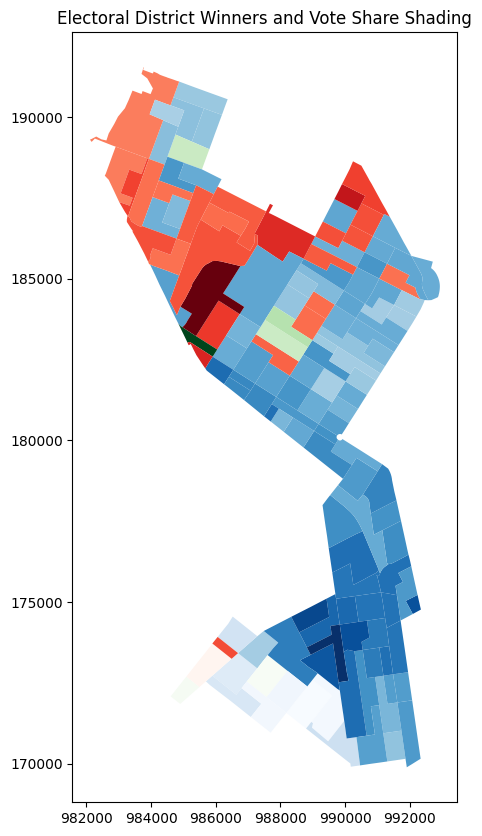

In [15]:
winners = gpd.GeoDataFrame(winners,geometry=winners['geometry'].apply(wkt.loads))
fig, ax = plt.subplots(1, figsize=(10, 10))
winners.plot(color=winners['color'], ax=ax)
ax.set_title("Electoral District Winners and Vote Share Shading")
plt.show()

In [16]:
d39.groupby('district_39_choice_1')['district_39_choice_2'].value_counts(dropna=False).reset_index(name='count').sort_values('count', ascending=False).head(10)

,district_39_choice_1,district_39_choice_2,count
59,Shahana K. Hanif,Brandon West,5003
0,Brandon West,Shahana K. Hanif,3762
60,Shahana K. Hanif,Justin M. Krebs,1888
61,Shahana K. Hanif,NaN,1818
20,Douglas M. Schneider,Justin M. Krebs,1640
1,Brandon West,NaN,1412
2,Brandon West,Justin M. Krebs,1390
39,Justin M. Krebs,NaN,1380
21,Douglas M. Schneider,NaN,1262
40,Justin M. Krebs,Shahana K. Hanif,1104


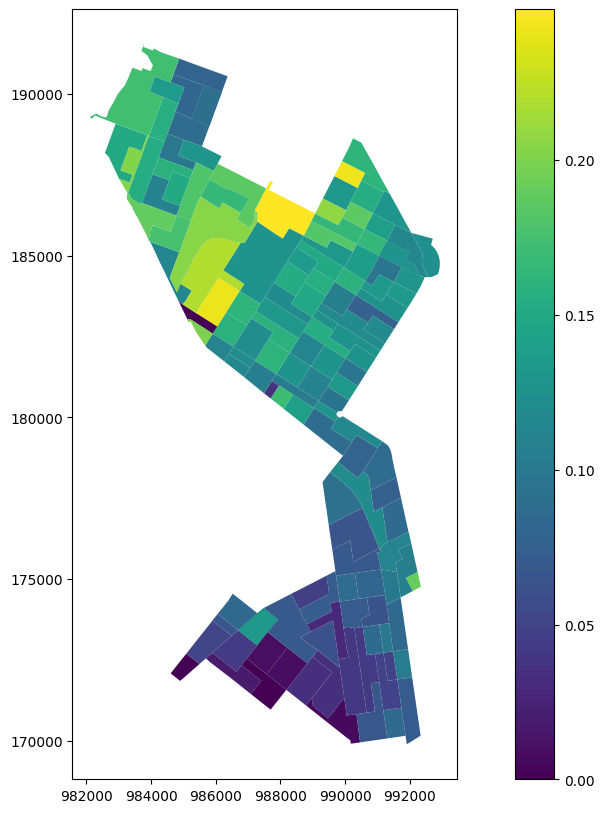

In [18]:
pc = make_precinct_counts(d39,'district_39','Shahana K. Hanif','Brandon West')
pc['total_votes'] = pc.iloc[:, 1:6].sum(axis=1)
pc = pc[['ed_name','Brandon West_notShahana K. Hanif','total_votes']]
pc.columns = ['ed_name','ch_notmh','total']
pc['ch_vote_share'] = pc['ch_notmh'] / pc['total']
el = full_results_thirty_nine[full_results_thirty_nine['winner'] == True]
map = pc.merge(el[['ed_name','geometry']],on='ed_name', how='left')
map = gpd.GeoDataFrame(map,geometry=map['geometry'].apply(wkt.loads))
map.plot(column='ch_vote_share', cmap='viridis', legend=True, figsize=(15, 10))
plt.show()

In [20]:
for col in occ_df.columns:
    print(col)

ElectDist
Shape_Leng
Shape_Area
geometry
w2
wm2
wm2mgt
w2mgt
wm2bizfin
w2ban
wm2cm
w2cm
wm2ae
w2ae
wm2lps
w2sci
wm2coss
w2coss
wm2legal
w2law
wm2educ
w2edu
wm2adesm
w2adm
wm2doc
w2doc
wm2ht
w2ht
wm2hs
w2hs
wm2ff
w2ff
wm2food
w2food
wm2bgcm
w2bg
wm2pcare
w2pserve
wm2sales
w2sale
wm2office
w2oad
wm2farm
w2farm
wm2cons
w2cons
wm2imr
w2emr
wm2prod
w2prod
wm2trans
w2trans
wm2mat
w2mat
wf2
wf2mgt
wf2bizfin
wf2cm
wf2ae
wf2lps
wf2coss
wf2legal
wf2educ
wf2adesm
wf2hpto
wf2doc
wf2ht
wf2hs
wf2ff
wf2food
wf2bgcm
wf2pcare
wf2sales
wf2office
wf2farm
wf2cons
wf2imr
wf2prod
wf2trans
wf2mat
wm2ag
wm2min
wm2con
wm2mfg
wm2whole
wm2retail
wm2tw
wm2util
wm2info
wm2fin
wm2re
wm2profsci
wm2cmgt
wm2admin
wm2ed
wm2hcss
wm2arts
wm2acfood
wm2osvc
wm2pubad
wf2ag
wf2min
wf2con
wf2mfg
wf2whole
wf2retail
wf2tw
wf2util
wf2info
wf2fin
wf2re
wf2profsci
wf2cmgt
wf2admin
wf2ed
wf2hcss
wf2arts
wf2acfppd
wf2osvc
wf2pubad
w2mgr
w2service
w2sales
w2conmaint
w2prodtran
wps2
wps2mgr
wps2service
wps2sales
wps2conmaint
wps2prodt

In [25]:
cor_cols = ['vote_share','white_transplant_ratio','w2npp','nhw21p','w2cossp','w2edup','dpp20bs','nhb21p','w2admp','w2hsp',
            'wm2mgt','mhhi21','cvap21bapp']
corr_df = bw_full.merge(occ_df, left_on='ed_name', right_on='ElectDist', how='left')
corr_matrix = corr_df[cor_cols].corr()
corr_matrix = corr_matrix.sort_values('vote_share')
vote_corr = corr_matrix[['vote_share']]

In [26]:
vote_corr

,vote_share
w2hsp,-0.486567
w2npp,-0.263708
w2edup,-0.179856
w2cossp,-0.053372
nhb21p,0.041394
nhw21p,0.061628
mhhi21,0.184997
wm2mgt,0.194801
w2admp,0.375569
dpp20bs,0.420333
